In [1]:
from attacksplitnn.splitnn import Client, Server, SplitNN
from attacksplitnn.attack.modelinversion.blackbox import Black_Box_Model_Inversion
from attacksplitnn.defense.nopeek import NoPeekLoss
from attacksplitnn.utils import DataSet

In [6]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from opacus import PrivacyEngine

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

In [7]:
config = {
    "batch_size":128
}

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.random.manual_seed(42)
print(device)

cpu


In [9]:
transform = transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

In [10]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

victim_idx = random.sample(range(trainset.data.shape[0]), k=2000) # seleciona quais dados vão ser passados para o cliente
victim_train_idx = victim_idx[:1000] # seleciona os 1000 primeiros dados para treinamento 
attack_idx = victim_idx[1000:] # a segunda metade dos dados será destinada ao atacante
victim_test_idx = random.sample(range(testset.data.shape[0]), k=15) # seleciona 15 dados para o teste

victim_train_dataset = Subset(trainset, victim_train_idx)
attack_dataset = Subset(trainset, attack_idx)
victim_test_dataset = Subset(testset, victim_test_idx)

victim_train_dataloader = torch.utils.data.DataLoader(victim_train_dataset, batch_size=64, shuffle=True)
attack_dataloader = torch.utils.data.DataLoader(attack_dataset, batch_size=64, shuffle=True)
victim_test_dataloader = torch.utils.data.DataLoader(victim_test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/home/eduarda/project_cybersecurity/env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
# Modelo do cliente
class FirstNet(nn.Module):
    def __init__(self):
        super(FirstNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64,
                               kernel_size=3, padding=1, stride=1)
        #self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        #self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        # 3ch > 64ch, shape 32 x 32 -> 16 x 16
        x = self.conv1(x) # [64,32,32]
        #x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [64,16,16]
        
        # 64ch > 128ch, shape 16 x 16 -> 8 x 8
        x = self.conv2(x) # [128,16,16]
        #x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [128,8,8]
        return x
    
# Modelo do servidor
class SecondNet(nn.Module):
    def __init__(self):
        super(SecondNet, self).__init__()
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.L1 = nn.Linear(512, 10) # Temos 10 classes

    def forward(self, x):
        # 128ch > 256ch, shape 8 x 8 -> 4 x 4
        x = self.conv3(x) # [256,8,8]
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [256,4,4]   

        # 256ch > 512ch, shape 4 x 4 -> 2 x 2
        x = self.conv4(x) # [512,4,4]
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [512,2,2]
        # camada totalmente conectada
        x = x.view(-1, 512)
        x = self.L1(x)
        #x = F.softmax(x, dim=0)
        return x


In [12]:
def accuracy(label, output):
    pred = output.argmax(dim=1, keepdim=True)
    return pred.eq(label.view_as(pred)).sum().item() / pred.shape[0]

In [13]:
model_1 = FirstNet()
model_1 = model_1.to(device)

model_2 = SecondNet()
model_2 = model_2.to(device)

opt_1 = optim.Adam(model_1.parameters(), lr=1e-3)
opt_2 = optim.Adam(model_2.parameters(), lr=1e-3)

criterion = NoPeekLoss(alpha=0.8)

In [16]:
import torch

class Client(torch.nn.Module):
    def __init__(self, client_model):
        super().__init__()
        """class that expresses the Client on SplitNN

        Args:
            client_model (torch model): client-side model

        Attributes:
            client_model (torch model): cliet-side model
            client_side_intermidiate (torch.Tensor): output of
                                                     client-side model
            grad_from_server
        """

        self.client_model = client_model
        self.client_side_intermidiate = None
        self.grad_from_server = None

    def forward(self, inputs):
        """client-side feed forward network

        Args:
            inputs (torch.Tensor): the input data

        Returns:
            intermidiate_to_server (torch.Tensor): the output of client-side
                                                   model which the client sent
                                                   to the server
        """

        self.client_side_intermidiate = self.client_model(inputs)
        # send intermidiate tensor to the server
        intermidiate_to_server = self.client_side_intermidiate.detach()\
            .requires_grad_()

        return intermidiate_to_server

    def client_backward(self, grad_from_server):
        """client-side back propagation

        Args:
            grad_from_server: gradient which the server send to the client
        """
        self.grad_from_server = grad_from_server
        self.client_side_intermidiate.backward(grad_from_server)

    def train(self):
        self.client_model.train()

    def eval(self):
        self.client_model.eval()


class Server(torch.nn.Module):
    def __init__(self, server_model):
        super().__init__()
        """class that expresses the Server on SplitNN

        Args:
            server_model (torch model): server-side model

        Attributes:
            server_model (torch model): server-side model
            intermidiate_to_server:
            grad_to_client
        """
        self.server_model = server_model

        self.intermidiate_to_server = None
        self.grad_to_client = None

    def forward(self, intermidiate_to_server):
        """server-side training

        Args:
            intermidiate_to_server (torch.Tensor): the output of client-side
                                                   model

        Returns:
            outputs (torch.Tensor): outputs of server-side model
        """
        self.intermidiate_to_server = intermidiate_to_server
        outputs = self.server_model(intermidiate_to_server)

        return outputs

    def server_backward(self):
        self.grad_to_client = self.intermidiate_to_server.grad.clone()
        return self.grad_to_client

    def train(self):
        self.server_model.train()

    def eval(self):
        self.server_model.eval()


class SplitNN(torch.nn.Module):
    def __init__(self, client, server,
                 client_optimizer, server_optimizer,
                 ):
        super().__init__()
        """class that expresses the whole architecture of SplitNN

        Args:
            client (attack_splitnn.splitnn.Client):
            server (attack_splitnn.splitnn.Server):
            clietn_optimizer
            server_optimizer

        Attributes:
            client (attack_splitnn.splitnn.Client):
            server (attack_splitnn.splitnn.Server):
            clietn_optimizer
            server_optimizer
        """
        self.client = client
        self.server = server
        self.client_optimizer = client_optimizer
        self.server_optimizer = server_optimizer

        self.intermidiate_to_server = None

    def forward(self, inputs):
        # execute client - feed forward network
        self.intermidiate_to_server = self.client(inputs)
        # execute server - feed forward netwoek
        outputs = self.server(self.intermidiate_to_server)

        return outputs

    def backward(self):
        # execute server - back propagation
        grad_to_client = self.server.server_backward()
        # execute client - back propagation
        self.client.client_backward(grad_to_client)

    def zero_grads(self):
        self.client_optimizer.zero_grad()
        self.server_optimizer.zero_grad()

    def step(self):
        self.client_optimizer.step()
        self.server_optimizer.step()

    def train(self):
        self.client.train()
        self.server.train()

    def eval(self):
        self.client.eval()
        self.server.eval()

In [17]:
client = Client(model_1)
server = Server(model_2)

splitnn = SplitNN(client, server, opt_1, opt_2)

In [11]:
splitnn.train()
for epoch in range(3):
    epoch_loss = 0
    epoch_outputs = []
    epoch_labels = []
    for i, data in enumerate(victim_train_dataloader):
        splitnn.zero_grads()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = splitnn(inputs)
        loss = criterion(inputs, splitnn.intermidiate_to_server, outputs, labels)
        loss.backward()

        epoch_loss += loss.item() / len(victim_train_dataloader.dataset)
        
        epoch_outputs.append(outputs)
        epoch_labels.append(labels)
        
        splitnn.backward()
        splitnn.step()
        
    print(epoch_loss, accuracy(torch.cat(epoch_labels),
                                torch.cat(epoch_outputs)))

0.0065544058233499534 0.59
0.0014446535110473637 0.939
0.0008919366002082822 0.97


In [18]:
# CNN
class Attacker(nn.Module):
    def __init__(self):
        super(Attacker, self).__init__()
        self.fla = nn.Flatten()
        self.ln1 = nn.Linear(128*7*7, 1000)
        self.ln2 = nn.Linear(1000, 784)

    def forward(self, x):
        x = self.fla(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.ln2(x)
        x = x.view(-1, 1, 28, 28)

        return x
    
attacker = Attacker()
attacker = attacker.to(device)

opt_3 = optim.Adam(attacker.parameters(), lr=1e-3)

In [19]:
bbmi = Black_Box_Model_Inversion(splitnn, attacker, opt_3)
bbmi.fit(attack_dataloader, 15)

/home/eduarda/project_cybersecurity/env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0: reconstruction_loss 0.5301318764686584
epoch 1: reconstruction_loss 0.4014522433280945
epoch 2: reconstruction_loss 0.33899879455566406
epoch 3: reconstruction_loss 0.28261086344718933
epoch 4: reconstruction_loss 0.24508468806743622
epoch 5: reconstruction_loss 0.2105766385793686
epoch 6: reconstruction_loss 0.20277181267738342
epoch 7: reconstruction_loss 0.20396511256694794
epoch 8: reconstruction_loss 0.19507533311843872
epoch 9: reconstruction_loss 0.1761299967765808
epoch 10: reconstruction_loss 0.16961190104484558
epoch 11: reconstruction_loss 0.16149775683879852
epoch 12: reconstruction_loss 0.1586018055677414
epoch 13: reconstruction_loss 0.14534753561019897
epoch 14: reconstruction_loss 0.1384386122226715


In [20]:
attack_result = bbmi.attack(victim_test_dataloader)
attack_result = attack_result.detach().numpy()

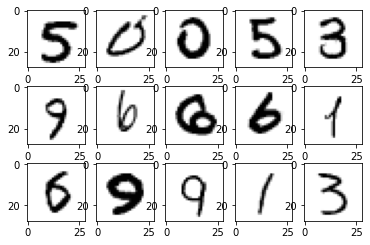

In [21]:
for data, _ in victim_test_dataloader:
    break
    
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(data[i-1].reshape(28,28),cmap='gray_r')

plt.show()

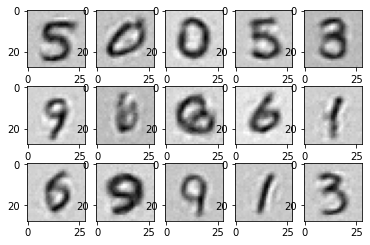

In [22]:
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(attack_result[i-1].reshape(28,28),cmap='gray_r')
#plt.title("reconstructed data")
plt.show()